In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import torch
import torch.nn as nn

In [2]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return (x - self.mean.type_as(x)[None, :, None, None]) / self.std.type_as(x)[None, :, None, None]

In [3]:
#!pip install pretrainedmodels
import pretrainedmodels
net = pretrainedmodels.__dict__['resnet152'](num_classes=1000, pretrained='imagenet')

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
height, width = net.input_size[1], net.input_size[2]
height, width

(224, 224)

In [5]:
net.mean

[0.485, 0.456, 0.406]

In [6]:
model_resnet152_sgm = nn.Sequential(Normalize(mean=net.mean, std=net.std), net)

# Load test images

In [7]:
import torchvision
import os

data_dir = 'D:/PFE black/4. Skip gradient method/1000subimagenet'

filenames = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png']

In [8]:
n_images = len(filenames)
test_images = torch.zeros(n_images, 3, 224, 224, dtype=torch.uint8)

In [9]:
for i, filename in enumerate(filenames):
    test_images[i] = torchvision.io.read_image(os.path.join(data_dir, filename))

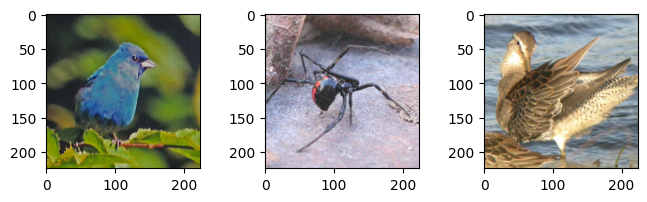

In [10]:
#display three randomly images
import random
fig = plt.figure(figsize=(8, 2))
n1,n2,n3 = random.sample(range(0, 1000), 3)
ax1, ax2, ax3 = fig.add_subplot(1, 3, 1),fig.add_subplot(1, 3, 2), fig.add_subplot(1, 3, 3)
ax1.imshow(test_images[n1].permute(1, 2, 0))
ax2.imshow(test_images[n2].permute(1, 2, 0))
ax3.imshow(test_images[n3].permute(1, 2, 0))

In [11]:
#make sure to change type of tensor to float and normalize between 0 and 1
x_test = test_images.float() / 255

In [12]:
y_test = torch.load('data/labels')

In [13]:
# batch_size = 20
# n_iterations = int(n_images/batch_size)
# with torch.no_grad():
#     model_resnet152_sgm.eval()
#     for i in n_iterations:
#         y_test = torch.argmax(torch.softmax(model_resnet152_sgm(x_test[i:i+batch_size,:,:,:]), dim=1),1)
#     y_test = torch.argmax(torch.softmax(model_resnet152_sgm(x_test), dim=1),1)
# torch.save(y_test, './data/labels')

In [14]:
# get label for one image
from PIL import Image
import torchvision
from torchvision import transforms
filename = "D:/PFE black/4. Skip gradient method/1000subimagenet/n01484850_ILSVRC2012_val_00028028.png"
input_image = Image.open(filename)
print(input_image)
preprocess = transforms.Compose([
    transforms.ToTensor()
])
input_tensor = preprocess(input_image)
print(input_tensor.shape)
with torch.no_grad():
    model_resnet152_sgm.eval()
    print(torch.max(model_resnet152_sgm(input_tensor), 1)[-1])

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x1F70E47ADC8>
torch.Size([3, 224, 224])
tensor([2])


# Comparing SGM, MI, DI

In [15]:
#!pip install git+https://github.com/RobustBench/robustbench.git
import torchattacks
import robustbench
from robustbench.utils import load_model, clean_accuracy

In [16]:
x_test_reserve, y_test_reserve = x_test.clone(), y_test.clone()

In [17]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

#we select randomly 20 images
ids = random.sample(range(0, 1000), 35)
ids

[654,
 114,
 25,
 759,
 281,
 250,
 228,
 142,
 754,
 104,
 692,
 758,
 913,
 558,
 89,
 604,
 432,
 32,
 30,
 95,
 223,
 238,
 517,
 616,
 27,
 574,
 203,
 733,
 665,
 718,
 429,
 225,
 459,
 603,
 284]

In [18]:
x_test, y_test = x_test_reserve[ids,:,:,:], y_test_reserve[ids]

- For this experiment, we use a subset with 1000 images from ImageNet
- we use the same source model "pretraine resnet152" for all the three methods
- for the target model : we test all three methods on **carmon** : _rank1_

### Skip gradient method SGM

We Generate adversarial examples and save them into path ./adv_images_SGM for ResNet-152 as the source model.  
Command used: python attack_sgm.py --gamma 0.5 --output_dir adv_images --arch resnet152 --batch-size 40

In [19]:
# get adv_images_SGM

In [20]:
data_dir = './adv_images_SGM'
filenames = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png']
n_images = len(filenames)
adv_images_SGM = torch.zeros(n_images, 3, 224, 224, dtype=torch.uint8)

for i, filename in enumerate(filenames):
    adv_images_SGM[i] = torchvision.io.read_image(os.path.join(data_dir, filename))

In [21]:
adv_images_SGM = adv_images_SGM.float() / 255

In [22]:
#select 30 examples
adv_images_SGM = adv_images_SGM[ids,:,:,:]

### Momentum iterative FGSM MI

In [23]:
attack = torchattacks.MIFGSM(model_resnet152_sgm, eps=8/255, steps=10, decay=1.0)
start_time = timeit.default_timer()
adv_images_MI = attack(x_test, y_test)
end_time = timeit.default_timer()

### Diversity input FGSM DI

In [24]:
attack = torchattacks.DIFGSM(model_resnet152_sgm, eps=8/255, alpha=2/255, steps=10, decay=0.0, resize_rate=0.9, diversity_prob=0.5, random_start=False)
start_time = timeit.default_timer()
adv_images_DI = attack(x_test, y_test)
end_time = timeit.default_timer()

In [25]:
### loading the target robust models from robustbench

In [26]:
from robustbench import load_model


model_4 = load_model(model_name='Salman2020Do_50_2', dataset='imagenet', threat_model='Linf')
model_6 = load_model(model_name='Engstrom2019Robustness', dataset='imagenet', threat_model='Linf')
model_7 = load_model(model_name='Wong2020Fast', dataset='imagenet', threat_model='Linf')
model_9 = load_model(model_name='Standard_R50', dataset='imagenet', threat_model='Linf')

c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
list_SGM = []

acc = clean_accuracy(model_4, adv_images_SGM, y_test)
print('Robust Acc 4_SGM: %2.2f %%'%(acc*100))
list_SGM.append(acc)

acc = clean_accuracy(model_6, adv_images_SGM, y_test)
print('Robust Acc 6_SGM: %2.2f %%'%(acc*100))
list_SGM.append(acc)

acc = clean_accuracy(model_7, adv_images_SGM, y_test)
print('Robust Acc 7_SGM: %2.2f %%'%(acc*100))
list_SGM.append(acc)

acc = clean_accuracy(model_9, adv_images_SGM, y_test)
print('Robust Acc 9_SGM: %2.2f %%'%(acc*100))
list_SGM.append(acc)

Robust Acc 4_SGM: 97.14 %
Robust Acc 6_SGM: 94.29 %
Robust Acc 7_SGM: 77.14 %
Robust Acc 9_SGM: 8.57 %


In [28]:
list_MI = []

acc = clean_accuracy(model_4, adv_images_MI, y_test)
print('Robust Acc 4_MI: %2.2f %%'%(acc*100))
list_MI.append(acc)

acc = clean_accuracy(model_6, adv_images_MI, y_test)
print('Robust Acc 6_MI: %2.2f %%'%(acc*100))
list_MI.append(acc)

acc = clean_accuracy(model_7, adv_images_MI, y_test)
print('Robust Acc 7_MI: %2.2f %%'%(acc*100))
list_MI.append(acc)

acc = clean_accuracy(model_9, adv_images_MI, y_test)
print('Robust Acc 9_MI: %2.2f %%'%(acc*100))
list_MI.append(acc)

Robust Acc 4_MI: 97.14 %
Robust Acc 6_MI: 94.29 %
Robust Acc 7_MI: 77.14 %
Robust Acc 9_MI: 17.14 %


In [29]:
list_DI = []

acc = clean_accuracy(model_4, adv_images_DI, y_test)
print('Robust Acc 4_DI: %2.2f %%'%(acc*100))
list_DI.append(acc)

acc = clean_accuracy(model_6, adv_images_DI, y_test)
print('Robust Acc 6_DI: %2.2f %%'%(acc*100))
list_DI.append(acc)

acc = clean_accuracy(model_7, adv_images_DI, y_test)
print('Robust Acc 7_DI: %2.2f %%'%(acc*100))
list_DI.append(acc)

acc = clean_accuracy(model_9, adv_images_DI, y_test)
print('Robust Acc 9_DI: %2.2f %%'%(acc*100))
list_DI.append(acc)

Robust Acc 4_DI: 97.14 %
Robust Acc 6_DI: 94.29 %
Robust Acc 7_DI: 80.00 %
Robust Acc 9_DI: 11.43 %


In [30]:
#barchart from trnfr attack